In [18]:
import geopandas as gpd
import pandas as pd
import yaml
from rasterio.crs import CRS
from pathlib import Path
import fiona
from shapely.ops import polygonize
from shapely.geometry import mapping, Polygon, shape
import glob

In [19]:
yaml_file = '../events/brazzaville_flood_and_landslides_2023.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'brazzaville_flood_and_landslides_2023',
 'bounds': [15.19418162, -4.31842285, 15.31481366, -4.13558505],
 'event_date': '2023-12-28',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [7, 109],
 'mgrs_tiles': ['33MWR'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange',
 'links': ['2024 and 2023 combined: https://data.humdata.org/dataset/water-and-landslide-mudflow-extents-in-brazzaville-department-republic-of-congo-as-of-8-fe',
  '2023: https://data.humdata.org/dataset/water-and-landslide-mudflow-extents-in-brazzaville-and-pool-departments-republic-of-congo-',
  '2024: https://global-flood.emergency.copernicus.eu/news/159-flooding-in-the-democratic-republic-of-the-congo-and-congo-brazzaville-january-2024']}

In [20]:
shp_files = glob.glob('../external_validation_data/unosat/FL20240102COG_SHP/*.shp')
shp_files

['../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_CloudObstruction_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/VIIRS_20231229_20240102_PermanentWater_Congo.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_FloodExtent_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/WV2_20240208_WaterExtent_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/GE1_20230513_WaterExtent_OverDam.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_LandslideExtent_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/S2_20231029_WaterExtent_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_AnalysisExtent_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/WV2_20240208_WaterExtent_OverDam.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/VIIRS_20231229_20240102_MinimumFloodWaterExtent_Congo.shp',
 '

In [21]:
shp_files_2023 = [p for p in shp_files if ('S2_20231228' in p) and (('Landslide' in p) or ('Flood' in p))]
shp_files_2023

['../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_FloodExtent_Brazaville.shp',
 '../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_LandslideExtent_Brazaville.shp']

In [22]:
dfs = [gpd.read_file(p)[['geometry']] for p in shp_files_2023]
df_event = pd.concat(dfs, axis=0).reset_index(drop=True)
df_event = df_event.to_crs(4326)
df_event.head()

,geometry
0,"MULTIPOLYGON (((15.20864 -4.31842, 15.20837 -4..."
1,"MULTIPOLYGON (((15.24069 -4.23629, 15.24069 -4..."


In [23]:
df_event.total_bounds

array([15.19418162, -4.31842285, 15.31481366, -4.13558505])

In [24]:
# df_flood_coastal = df_flood.cx[89.2:91, 21.5: 24].reset_index(drop=True)
# df_flood_coastal.explore()

In [25]:
n = df_event.shape[0]
df_event_f = gpd.GeoDataFrame({'name': [event_dict['event_name'] for k in range(n)],
                               'date': [pd.to_datetime(event_dict['event_date']) for k in range(n)],
                               'source_id': [f'{event_dict["source_id"]}' for k in range(n)]},
                              geometry=df_event.geometry.tolist(),
                              crs=CRS.from_epsg(4326))
df_event_f.head()

,name,date,source_id,geometry
0,brazzaville_flood_and_landslides_2023,2023-12-28,UNOSAT via humanitarian data exchange,"MULTIPOLYGON (((15.20864 -4.31842, 15.20837 -4..."
1,brazzaville_flood_and_landslides_2023,2023-12-28,UNOSAT via humanitarian data exchange,"MULTIPOLYGON (((15.24069 -4.23629, 15.24069 -4..."


In [26]:
EXTERNAL_VAL_DATA_DIR = Path('../external_validation_data_db/')
EXTERNAL_VAL_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [27]:
#df_event_f.to_parquet(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.parquet')

In [28]:
df_event_f.to_file(EXTERNAL_VAL_DATA_DIR / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')

In [29]:
shp_files_aoi = [p for p in shp_files if ('S2_2023' in p) and (('AnalysisExtent' in p))]
shp_files_aoi

['../external_validation_data/unosat/FL20240102COG_SHP/S2_20231228_AnalysisExtent_Brazaville.shp']

In [30]:
dfs_aoi = [gpd.read_file(p)[['geometry']] for p in shp_files_aoi]
df_aoi = pd.concat(dfs_aoi, axis=0).reset_index(drop=True)
df_aoi.head()

,geometry
0,"POLYGON ((15.31364 -4.11326, 15.31364 -4.11330..."


<Axes: >

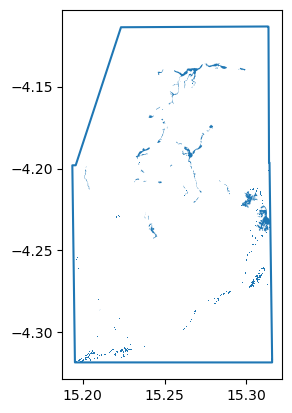

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df_aoi.boundary.plot(ax=ax)
df_event.plot(ax=ax)

In [32]:
EXTERNAL_VAL_EXTENTS = Path('../external_validation_data_extents_db/')
EXTERNAL_VAL_EXTENTS.mkdir(exist_ok=True, parents=True)

df_aoi.to_file(EXTERNAL_VAL_EXTENTS / f'{event_dict["event_name"]}.geojson', driver='GeoJSON')